# Self Study 5


In this self study we implement and test a simple Markov network model for node prediction, and a Gibbs sampling inference (prediction) process. 

For this material there is no direct support from scikit learn, so we have to do a little more coding ourselves than before ...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx import read_edgelist
from sklearn.metrics import accuracy_score
import random
import math

from ipywidgets import IntProgress
from IPython.display import display

C:\Users\inigo\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\inigo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\inigo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


As in the previous self study we use the Lazega lawyer network. This time we load it in a slightly different format, in which we first just construct an networkx graph from the 'friendship' edges, and constuct a separate Pandas dataframe for the node attributes. The process of how attributes from this table are turned into attributes for the nodes in the networkx graph can serve as a template for how to construct additional node attributes (not necessarily only the predefined ones from lazega-attributes.txt). 


In [2]:
lazega=read_edgelist('lazega-friends.edges.txt',nodetype=int) 
node_atts=pd.read_csv("lazega-attributes.txt", sep=' ')
display(node_atts)

,nodeID,nodeStatus,nodeGender,nodeOffice,nodeSeniority,nodeAge,nodePractice,nodeLawSchool
0,1,1,1,1,31,64,1,1
1,2,1,1,1,32,62,2,1
2,3,1,1,2,13,67,1,1
3,4,1,1,1,31,59,2,3
4,5,1,1,2,31,59,1,2
...,...,...,...,...,...,...,...,...
66,67,2,2,1,1,35,1,2
67,68,2,1,1,1,26,1,3
68,69,2,2,1,1,38,1,3
69,70,2,1,1,1,31,2,2


Now we annotate the nodes in the graph with some selected attributes (later on, if you want to do more, you can consider additional attributes). 

In [3]:

for i in range(node_atts.shape[0]):
    lazega.add_node(node_atts.loc[i,'nodeID'], gender=node_atts.loc[i,'nodeGender'])
    lazega.add_node(node_atts.loc[i,'nodeID'], seniority=node_atts.loc[i,'nodeSeniority'])
    lazega.add_node(node_atts.loc[i,'nodeID'], office=node_atts.loc[i,'nodeOffice'])
    lazega.add_node(node_atts.loc[i,'nodeID'], true_practice=node_atts.loc[i,'nodePractice'])

In [4]:
def init_graph(show_graphs = False):
    colors = ["yellow", "blue", "red"]
    lazega=read_edgelist('lazega-friends.edges.txt',nodetype=int) 
    node_atts=pd.read_csv("lazega-attributes.txt", sep=' ')
    
    for i in range(node_atts.shape[0]):
        lazega.add_node(node_atts.loc[i,'nodeID'], gender=node_atts.loc[i,'nodeGender'])
        lazega.add_node(node_atts.loc[i,'nodeID'], seniority=node_atts.loc[i,'nodeSeniority'])
        lazega.add_node(node_atts.loc[i,'nodeID'], office=node_atts.loc[i,'nodeOffice'])
        lazega.add_node(node_atts.loc[i,'nodeID'], true_practice=node_atts.loc[i,'nodePractice'])
    
    random.seed(5)
    for i in range(node_atts.shape[0]):
        if random.random() > 0.4:
            lazega.add_node(node_atts.loc[i,'nodeID'], observed_practice=node_atts.loc[i,'nodePractice'])
        else:
            lazega.add_node(node_atts.loc[i,'nodeID'], observed_practice=np.nan)
    
    lazega = init_practice(lazega, node_atts)
    
    l =  []
    for i in lazega.nodes():
        obvP = lazega.nodes[i]['observed_practice']
        if math.isnan(obvP):
            l.append(colors[0])
        else:
            l.append(colors[obvP])
    
    if (show_graphs):
        nx.draw_kamada_kawai(lazega,with_labels=True,node_color=l)
        plt.show()
    
    return lazega

The 'practice' attribute is going to be our class label that we want to predict. Therfore, we pretend that this attribute is not observed for some randomly selected nodes. We do this by adding a new attribute 'observed_practice' which has either the true practice value, or 'nan' for unobserved.

In [5]:
random.seed(5)
for i in range(node_atts.shape[0]):
    if random.random() > 0.4:
        lazega.add_node(node_atts.loc[i,'nodeID'], observed_practice=node_atts.loc[i,'nodePractice'])
    else:
        lazega.add_node(node_atts.loc[i,'nodeID'], observed_practice=np.nan)

We now want to predict the missing 'practice' labels using Gibbs sampling on a Markov network model. We will first need to initialize values for the unobserved attributes. 

**Task 1:** complete the following function:

In [6]:
node_atts

,nodeID,nodeStatus,nodeGender,nodeOffice,nodeSeniority,nodeAge,nodePractice,nodeLawSchool
0,1,1,1,1,31,64,1,1
1,2,1,1,1,32,62,2,1
2,3,1,1,2,13,67,1,1
3,4,1,1,1,31,59,2,3
4,5,1,1,2,31,59,1,2
...,...,...,...,...,...,...,...,...
66,67,2,2,1,1,35,1,2
67,68,2,1,1,1,26,1,3
68,69,2,2,1,1,38,1,3
69,70,2,1,1,1,31,2,2


In [7]:
def init_practice(G, node_atts):
    # This function should add an additional attribute predicted_practice.
    # The value of predicted_practices is the same as observed_practice when observed_practice != nan. Otherwise, 
    # predicted_practice is a randomly sampled 'practice' value.
    
    possible_practices = list(set(node_atts.loc[:,'nodePractice']))
    for i in range(node_atts.shape[0]):
        if (math.isnan(G.nodes[node_atts.loc[i, 'nodeID']]['observed_practice'])):
            lazega.add_node(node_atts.loc[i, 'nodeID'], predicted_practice = random.choice(possible_practices))
        else:
            lazega.add_node(node_atts.loc[i, 'nodeID'], predicted_practice = node_atts.loc[i,'nodePractice'])
    return lazega

In [8]:
init_practice(lazega, node_atts)

We next define some potential functions. Mostly we will be using node or edge potentials, i.e., potential functions that
depend only on the attributes of a single node, or on the attributes of two nodes (connected by an edge). 

Instead of defining the potential function directly, it is more convenient to first define the log of the potential function. Then, instead of taking a big product (cf. slide 7), one can first take the sum of relevant potentials, and apply an exponential at the end. E.g., the log of the homophily potential (slide 21) is w in the case A_i=A_j, and 0 otherwise. Also, all real numbers are then permissible return values, without the non-negativity condition.

The following are examples of a simple node (log-)potential and an "ising-style" homophily potential. Both potential functions depend on numerical parameters w1,w2. You may start with using these two log-potentials only, and later define additional potential functions.

In [9]:
def n_log_potential_1(n,w1,w2):
    if n['gender'] == 1: return w1 # we apply the exponential after all relevant potentials, for simplicity.
    else: return w2

In [10]:
def n_log_potential_2(n1,n2,w1,w2):
    if n1['predicted_practice']==n2['predicted_practice']: return w1
    else: return w2

In [11]:
def n_log_potential_seniority(n,w1,w2):
    if n['seniority'] == 1: return w1 # we apply the exponential after all relevant potentials, for simplicity.
    else: return w2

In [12]:
print(n_log_potential_1(lazega.nodes[5],-1,1)) # gender of N5 is 1 so returns -1
print(n_log_potential_2(lazega.nodes[5],lazega.nodes[6],-2,3)) # predicted practices of N5 and N6 are the same so returns -2

-1
-2


**Task 2:** Write a Gibbs-sampling function for re-sampling the 'predicted_practice' attribute value for a node *n*. At this point we need not worry whether for *n* the actual 'practice' value is known or not.

In [13]:
def gibbs_sample(n, lazega, w1, w2, node_pot, edge_pot):
    # Iterate over all log-potential functions you want to use
    # For node potentials, evaluate the potential for the given node n
    # For edge potentials, evaluate the potential for all pairs (n,n') where n' is a neighbor in the 'friendship' graph.
    #
    # Since the friendship graph is directed, there are three possibilities of how to do this precisely:
    #        - consider all n' where friends(n,n')
    #        - consider all n' where friends(n',n)
    #        - consider both cases of n'
    # 
    # The method nx.all_neighbors(lazega,n) will return an iterator over both types of neighbors of n, so the third
    # option is the most convenient to use (and maybe also the most sensible)
    #
    node = lazega.nodes[n]
    node_pot = node_pot(node, w1, w2)
    edge_pots_val0 = []
    edge_pots_val1 = []
    
    for i in nx.all_neighbors(lazega, n):        
        otherNode = lazega.nodes[i]
        if otherNode['predicted_practice'] == 1:
            edge_pots_val0.append(edge_pot(node,otherNode,w1,w2))
        else:
            edge_pots_val1.append(edge_pot(node,otherNode,w1,w2))
    
    # Sum the values of all the potential functions, and take the exponential.
    # This has to be done for both possible values of the 'predicted_practice' value for n
    #
    
    
    #tot_pot = math.exp(node_pot + sum(edge_pots))
    
    # When the potential functions are defined with some free numerical parameters (as w1,w2 above), then at 
    # some point these parameters must be set to fixed values.
    
    
    # Calculate the probability for predicted_practice(n) according to the quotient shown on slide 22 (see also 
    # the example on slide 28)
    #
    
    val0_val1 = (sum(edge_pots_val0) - sum(edge_pots_val1))
    val1_val0 = (sum(edge_pots_val1) - sum(edge_pots_val0))
    if node['predicted_practice'] == 1:
        val0_val1 += node_pot
    else:
        val1_val0 += node_pot
    
    val0_val1 = math.exp(val0_val1)
    val1_val0 = math.exp(val1_val0)
    
    
    prob = val0_val1 / (val0_val1 + val1_val0)
    random_num = random.uniform(0, 1)
    

    if (random_num <= prob):
        lazega.nodes[n]['predicted_practice'] = 1
    else:
        lazega.nodes[n]['predicted_practice'] = 2
    
    return lazega
    
    # Set the new value of predicted_practice(n) randomly according to the probabilities you have just computed. 

Once the resampling of the predicted_practice attribute for a single node is in place, the rest is quite straightforward: 

**Task 3**: Write a function that performs one round of Gibbs sampling, i.e., re-samples the predicted values for all nodes for which the class attribute is unknown.

In [14]:
def gibbs_one_round(G, w1, w2, node_pot, edge_pot):
    nodes = G.nodes()
    for idx in nodes:
        if (math.isnan(nodes[idx]['observed_practice'])):
            G = gibbs_sample(idx, G, w1, w2, node_pot, edge_pot)
    return G
    # Iterate over all nodes n in G for which observed_practice == nan, and re-sample its predicted_practice value

In [15]:
def count_predicted_nan(G):
    d = lazega.nodes()
    count = [0,0]
    for i in d:
        if (math.isnan(d[i]['observed_practice'])):
            if d[i]['predicted_practice'] == 1:
                count[0] += 1
            else:
                count[1] += 1
    return count[0], count[1]

Now we can put everything together to use our model to predict the 'practice' attribute. 

**Task 4**: write code for doing the following:

In [16]:
def gibbs_predict(N, w1, w2, node_pot, edge_pot, show_graphs = False, print_log = False):
    # Initialize with init_att
    #
    lazega = init_graph(show_graphs) 
    
    # Perform a number of gibbs_one_round(lazega) sampling steps
    # (Maybe after a certain number of burn-in iterations): keep count of how often the predicted_practice value of nodes 
    # with observed_practice == nan is in the two states 1 or 2.
    # 
    for i in range(N):
        lazega= gibbs_one_round(lazega, w1, w2, node_pot, edge_pot)
        if (i >= math.floor(N * .3) and print_log):
            nodes = lazega.nodes()
            fst, snd = count_predicted_nan(lazega)
            print("Iteration {}\n State 1: {} \n State 2: {}".format(i, fst, snd))
    # Predict the unobserved practice values as the more probably state in the Gibbs sample
    #
    # Compare your predicted values against the true values
    trues = np.array([])
    preds = np.array([])
    for i in lazega.nodes():
        if math.isnan(lazega.nodes[i]['observed_practice']):
            trues = np.append(trues, [lazega.nodes[i]['true_practice']])
            preds = np.append(preds, [lazega.nodes[i]['predicted_practice']])
    
    l =  []
    colors = ['yellow','blue','red']
    for i in lazega.nodes():
        obvP = lazega.nodes[i]['predicted_practice']
        l.append(colors[obvP])
    
    acc = accuracy_score(preds,trues)
    preds1 = len(np.where(preds == 1)[0])/len(preds)
    preds2 = len(np.where(preds == 2)[0])/len(preds)
    
    if (show_graphs):
        nx.draw_kamada_kawai(lazega,with_labels=True,node_color=l)
        plt.show()
    
        print("Accuracy: {}".format(acc))
        print("Frequency of class 1: {} \nFrequency of class 2: {}".format(preds1, preds2))
    
    return acc, preds1, preds2

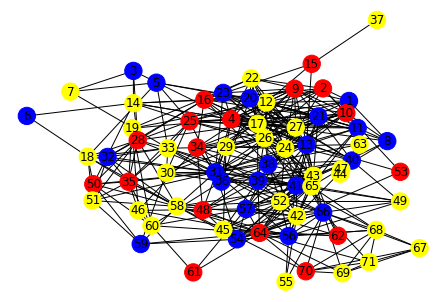

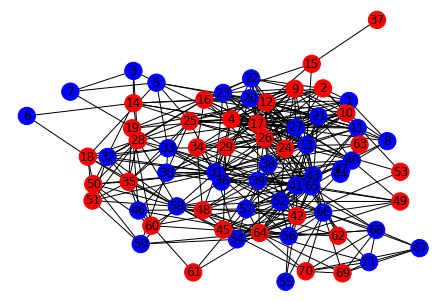

Accuracy: 0.71875
Frequency of class 1: 0.5 
Frequency of class 2: 0.5


(0.71875, 0.5, 0.5)

In [17]:
gibbs_predict(1, 1, -1, node_pot = n_log_potential_seniority, edge_pot = n_log_potential_2, show_graphs = True)
#gibbs_predict(9000)

Now that things are up and running, we can explore some of the properties of the model and the Gibbs sampling procedure: 

**Task 5**: 

<ul>
<li> Perform the Gibbs-prediction procedure several times and explore how stable the prediction results are. Apart from the final categorical prediction, you can also consider the actual frequencies of the two 'predicted_practice" states in your samples</li>
    <li> Try different settings of the parameter values of the potential functions. Can you find a relationship between the parameter values, and the stability of the Gibbs sampling? </li>
    <li> Also try different parameter settings in order to optimize prediction accuracy. In a real application, one would learn the parameter values by likelihood optimization based on the labeled training nodes. This is outside the scope of what we can do here, so let's do a simple grid search over parameter values instead (ugly!) and evaluate by checking accuracy using the known actual labels for the test nodes (this evaluation would usually be done on a set of validation nodes that is distinct from the final test nodes, but we need not worry about this distinction here).
    </ul>

In [18]:
N = np.arange(1,100,1)
f = IntProgress(min=0, max=len(N))
display(f)

res_acc = []
res_preds1 = []
res_preds2 = []
for i in N:
    acc, p1, p2 = gibbs_predict(i, .5,-.5, node_pot = n_log_potential_seniority, edge_pot = n_log_potential_2)
    res_acc += [acc]
    res_preds1 += [p1]
    res_preds2 += [p2]
    f.value += 1


IntProgress(value=0, max=99)

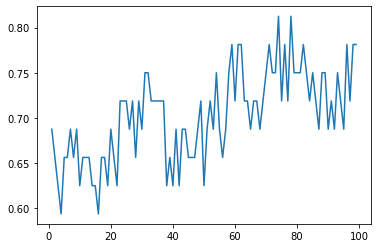

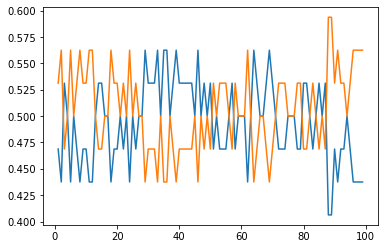

In [19]:
plt.plot(N, res_acc)
plt.show()
plt.plot(N, res_preds1)
plt.plot(N,res_preds2)

In [20]:
N = np.arange(1,100,1)
f = IntProgress(min=0, max=len(N))
display(f)

res_acc = []
res_preds1 = []
res_preds2 = []
for i in N:
    acc, p1, p2 = gibbs_predict(i, .1,-.1, node_pot = n_log_potential_seniority, edge_pot = n_log_potential_2)
    res_acc += [acc]
    res_preds1 += [p1]
    res_preds2 += [p2]
    f.value += 1


IntProgress(value=0, max=99)

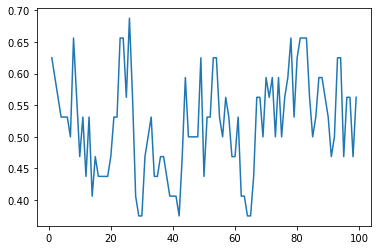

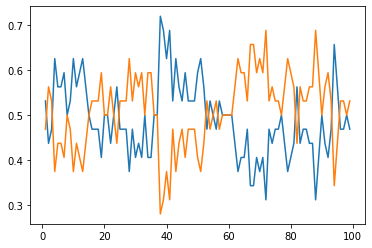

In [21]:
plt.plot(N, res_acc)
plt.show()
plt.plot(N, res_preds1)
plt.plot(N,res_preds2)

## Exploration

In [22]:
node_atts.corr()

,nodeID,nodeStatus,nodeGender,nodeOffice,nodeSeniority,nodeAge,nodePractice,nodeLawSchool
nodeID,1.000000,0.866025,0.409167,-0.107127,-0.883945,-0.818956,-0.082087,0.345272
nodeStatus,0.866025,1.000000,0.396762,-0.062522,-0.758115,-0.618663,-0.044983,0.208261
nodeGender,0.409167,0.396762,1.000000,-0.101213,-0.387374,-0.204196,0.025848,-0.055465
nodeOffice,-0.107127,-0.062522,-0.101213,1.000000,-0.035550,0.075436,0.125200,0.096427
nodeSeniority,-0.883945,-0.758115,-0.387374,-0.035550,1.000000,0.776590,0.089962,-0.297327
nodeAge,-0.818956,-0.618663,-0.204196,0.075436,0.776590,1.000000,0.097037,-0.380406
nodePractice,-0.082087,-0.044983,0.025848,0.125200,0.089962,0.097037,1.000000,-0.056280
nodeLawSchool,0.345272,0.208261,-0.055465,0.096427,-0.297327,-0.380406,-0.056280,1.000000


**The smaller the weights, the less stable the predictions**, since the probability of the nodes changing increases (less weight).

As we can see in the correlation table, it seems that nodePractice is the most correlated (barely) with nodeOffice, therefore we can use this to somewhat exploit the node potential.

Let us do the grid search now:

In [50]:
N = np.arange(1,50,5)
w1 = np.arange(-1,1,.25)
w2 = np.arange(-1,1,.25)
f = IntProgress(min=0, max=(len(N)*len(w1)*len(w2)))
display(f)

res_acc = []
params = []
for i in N:
    for j in w1:
        for k in w2:
            acc = gibbs_predict(i, j,k, node_pot = n_log_potential_seniority, edge_pot = n_log_potential_2)
            res_acc += [acc[0]]
            params += [(i,j,k)]
            f.value += 1
res_acc = np.array(res_acc)
params = np.array(params)
print("Best accuracy: {}".format(max(res_acc)))
print("Best params: {}" .format(params[np.where(res_acc == res_acc.max())][0]))

IntProgress(value=0, max=640)

Best accuracy: 0.84375
Best params: [21.    0.5   0.25]


## Testing area

In [23]:
def gibbs_sample_test(n, lazega, w1, w2):
    # Iterate over all log-potential functions you want to use
    # For node potentials, evaluate the potential for the given node n
    # For edge potentials, evaluate the potential for all pairs (n,n') where n' is a neighbor in the 'friendship' graph.
    #
    # Since the friendship graph is directed, there are three possibilities of how to do this precisely:
    #        - consider all n' where friends(n,n')
    #        - consider all n' where friends(n',n)
    #        - consider both cases of n'
    # 
    # The method nx.all_neighbors(lazega,n) will return an iterator over both types of neighbors of n, so the third
    # option is the most convenient to use (and maybe also the most sensible)
    #
    node = lazega.nodes[n]
    node_pot = n_log_potential_seniority(node, w1, w2)
    edge_pots_val0 = []
    edge_pots_val1 = []
    
    for i in nx.all_neighbors(lazega, n):        
        otherNode = lazega.nodes[i]
        if otherNode['predicted_practice'] == 1:
            edge_pots_val0.append(n_log_potential_2(node,otherNode,w1,w2))
        else:
            edge_pots_val1.append(n_log_potential_2(node,otherNode,w1,w2))
    
    # Sum the values of all the potential functions, and take the exponential.
    # This has to be done for both possible values of the 'predicted_practice' value for n
    #
    
    
    #tot_pot = math.exp(node_pot + sum(edge_pots))
    
    # When the potential functions are defined with some free numerical parameters (as w1,w2 above), then at 
    # some point these parameters must be set to fixed values.
    
    
    # Calculate the probability for predicted_practice(n) according to the quotient shown on slide 22 (see also 
    # the example on slide 28)
    #
    print("Node potential: {}".format(node_pot))
    print("Edge potentials class 1: {}".format(edge_pots_val0))
    print("Edge potentials class 2: {}".format(edge_pots_val1))
    
    val0_val1 = (sum(edge_pots_val0) - sum(edge_pots_val1))
    val1_val0 = (sum(edge_pots_val1) - sum(edge_pots_val0))
    if node['predicted_practice'] == 1:
        val0_val1 += node_pot
    else:
        val1_val0 += node_pot
    
    val0_val1 = math.exp(val0_val1)
    val1_val0 = math.exp(val1_val0)
    
    print("Summed potentials class 1: {}".format(val0_val1))
    print("Summed potentials class 2: {}".format(val1_val0))
    
    prob = val0_val1 / (val0_val1 + val1_val0)
    random_num = random.uniform(0, 1)
    
    print("Probability of being blue for node {}: {}".format(n, prob))
    print("Random num: {} ".format(random_num))

    if (random_num <= prob):
        lazega.nodes[n]['predicted_practice'] = 1
        print("Must be blue!")
    else:
        lazega.nodes[n]['predicted_practice'] = 2
        print("Must be red!")
    
    if (lazega.nodes[n]['true_practice'] == 1):
        print("And it actually is BLUE")
    else:
        print("And it actually is RED")
        
    return lazega
    
    # Set the new value of predicted_practice(n) randomly according to the probabilities you have just computed. 

In [24]:
idx = 61
for i in nx.all_neighbors(lazega, idx):
    print(str(i) + " - " + str(lazega.nodes[i]['predicted_practice']))
    print("Potential: {}".format(n_log_potential_2(lazega.nodes[idx],lazega.nodes[i],1,-1)))

57 - 1
Potential: -1
60 - 2
Potential: 1
64 - 2
Potential: 1


Node potential: -1
Edge potentials class 1: []
Edge potentials class 2: [-1]
Summed potentials class 1: 1.0
Summed potentials class 2: 0.36787944117144233
Probability of being blue for node 37: 0.7310585786300049
Random num: 0.7913693279476295 
Must be red!
And it actually is RED


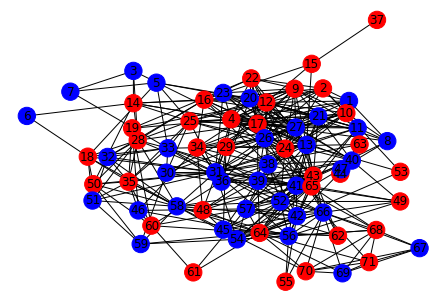

In [28]:
idx = 37
ltest = gibbs_sample_test(idx, lazega, 1, -1)

l =  []
colors = ['yellow','blue','red']
for i in ltest.nodes():
    obvP = ltest.nodes[i]['predicted_practice']
    l.append(colors[obvP])
nx.draw_kamada_kawai(lazega,with_labels=True,node_color=l)
plt.show()